<a href="https://colab.research.google.com/github/wayoo2019/DS-Capstone-Projects/blob/main/Amazon_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1: Descriptive Analysis

DSC 483 Capstone Mini Project

*   Yuan Wang
*   Shijing Li

In [ ]:
# mount Google Drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load the regular expression library
import re
# Import the wordcloud library
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Mini Project/amazon_reviews.csv')

load after processed (part 1) amazon df to avoid time consuming

In [ ]:
%%time
df = pd.read_parquet("/content/drive/MyDrive/Mini Project/amazon_reviews.parquet.gzip")

Convert delta time to datetime format

In [ ]:
startdate = datetime.datetime.strptime('1970-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
df['Time'] = df['Time'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

#### a) 
Create a table that contains information on minimum, average, median, and maximum for the following: title length, summary length, score, helpfulness ratio (helpfulness numerator divided by helpfulness denominator) (Add your table to the report at the end.) (10 points for undergraduate students, 5 points for graduate students)

In [ ]:
df['Title_len'] = df['ProfileName'].str.len()
df['Summary_len'] = df['Summary'].str.len()
df['Helpful_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['Review_len'] = df['Text'].str.len()

In [ ]:
feature_list = ['Title_len', 'Summary_len', 'Score', 'Helpful_ratio']
table1 = pd.DataFrame(index=['Title_len', 'Summary_len', 'Score', 'Helpful_ratio'], columns=['Min', 'Mean', 'Max', 'Median'])
table1['Min'] = df[feature_list].min()
table1['Mean'] = df[feature_list].mean()
table1['Max'] = df[feature_list].max()
table1['Median'] = df[feature_list].median()
table1

,Min,Mean,Max,Median
Title_len,1.0,13.804964,49.0,11.0
Summary_len,1.0,23.446858,128.0,20.0
Score,1.0,4.183199,5.0,5.0
Helpful_ratio,0.0,0.776975,3.0,1.0


#### b)
Create four line graphs with the following variables aggregated by day over time: review length, summary length, score, helpfulness ratio (helpfulness numerator divided by helpfulness denominator) – the horizontal axis should correspond to time. Do you observe any patterns or interesting trends? Write your findings in the report. (Add the line graphs to the report at the end.) (10 points for undergraduate students, 5 points for graduate students)

In [ ]:
table2 = df[['Time', 'Review_len', 'Summary_len', 'Score', 'Helpful_ratio']].groupby(['Time']).agg(['mean'])
table2.columns = ['Review_len_mean', 'Summary_len_mean', 'Score_mean', 'Helpful_ratio_mean']
table2 = table2.reset_index()
table2

,Time,Review_len_mean,Summary_len_mean,Score_mean,Helpful_ratio_mean
0,1999-10-08,375.000000,25.000000,5.000000,NaN
1,1999-10-25,407.000000,60.000000,5.000000,1.000000
2,1999-12-02,166.000000,20.000000,5.000000,NaN
3,1999-12-06,222.000000,23.000000,5.000000,0.500000
4,2000-01-03,244.000000,10.000000,5.000000,NaN
...,...,...,...,...,...
3163,2012-10-22,417.025492,23.512167,4.009270,0.854610
3164,2012-10-23,373.058126,22.456702,4.233689,0.796296
3165,2012-10-24,355.812941,21.910588,4.251765,0.964286
3166,2012-10-25,386.945274,24.500000,4.121891,0.812500


In [ ]:
table2['Review_len_mean'].mode(), table2['Summary_len_mean'].mode(), table2['Score_mean'].mode(), table2['Helpful_ratio_mean'].mode()

(0    314.0
 dtype: float64, 0    20.0
 dtype: float64, 0    5.0
 dtype: float64, 0    1.0
 dtype: float64)

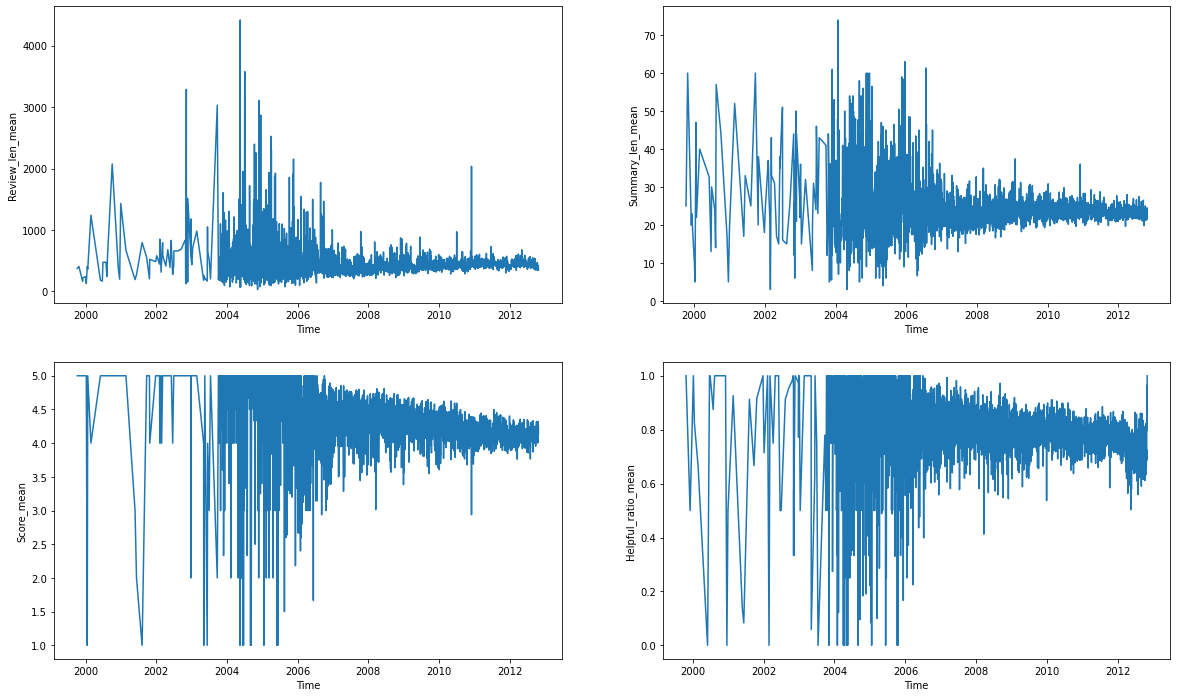

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=[20,12])
sns.lineplot(x='Time', y='Review_len_mean', data=table2, ax=ax[0,0])
sns.lineplot(x='Time', y='Summary_len_mean', data=table2, ax=ax[0,1])
sns.lineplot(x='Time', y='Score_mean', data=table2, ax=ax[1,0])
sns.lineplot(x='Time', y='Helpful_ratio_mean', data=table2, ax=ax[1,1])

From all four-line graphs, we can see that from 2000 to 2003, the distributions of length of reviews, length of summary, score and helpfulness ratio all showed to be pretty spread out. The variance of the value is very large. From 2004 to 2006, they all reach to a peak. After 2006, everything gets to its consistent state. The range becomes dramatically smaller and the frequency remains high. One reason behind this may be that from 1998-2004 is when amazon started to expand its services to fine food, the smaller group of customers made the rating range more fluctuated.







#### c)
Using the lda_tutorial.pdf file in the assignment folder, perform a Latent Dirichlet Allocation (LDA) analysis to extract the topics in the Text column in an unsupervised manner. Set the number of clusters/topics to 5 (five). What are your observations? Does each cluster seem to form a meaningful subset? What do they seem to represent (Add the clusters and your observations to the report at the end.) (10 points for undergraduate students, 5 points for graduate students)

In [ ]:
# Remove punctuation
df['Text_processed'] = df['Text'].map(lambda x: re.sub(r'[^\w\s]', '', x))

# Convert the titles to lowercase
df['Text_processed'] = df['Text'].map(lambda x: x.lower())

# Print out the first rows of papers
df['Text_processed'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price.  there was a wid...
Name: Text_processed, dtype: object

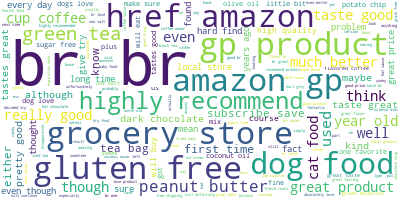

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['Text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'br', 'http', 'com', 'www', 'href', 've'])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df.Text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]


In [ ]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"coffee" + 0.038*"tea" + 0.017*"cup" + 0.015*"like" + 0.014*"flavor" '
  '+ 0.011*"good" + 0.011*"taste" + 0.010*"one" + 0.008*"cups" + '
  '0.008*"green"'),
 (1,
  '0.024*"food" + 0.016*"dog" + 0.010*"treats" + 0.009*"one" + 0.008*"dogs" + '
  '0.008*"like" + 0.007*"cat" + 0.007*"loves" + 0.007*"treat" + 0.006*"eat"'),
 (2,
  '0.018*"amazon" + 0.014*"product" + 0.012*"price" + 0.010*"great" + '
  '0.009*"buy" + 0.008*"box" + 0.008*"order" + 0.008*"good" + 0.008*"store" + '
  '0.008*"find"'),
 (3,
  '0.014*"like" + 0.012*"good" + 0.012*"great" + 0.010*"flavor" + '
  '0.010*"taste" + 0.009*"chips" + 0.008*"love" + 0.007*"salt" + 0.007*"oil" + '
  '0.007*"eat"'),
 (4,
  '0.021*"like" + 0.018*"taste" + 0.013*"sugar" + 0.010*"flavor" + '
  '0.009*"good" + 0.009*"water" + 0.008*"product" + 0.008*"one" + '
  '0.008*"sweet" + 0.007*"chocolate"')]


Key text visualizaton

In [ ]:

!pip install gensim
!pip install pyLDAvis
!pip install vega
!pip install altair


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 


**Warning:** read this before you want to run below codes:

pyLDAvis.gensim_models.prepare occurs error "A result has failed to un-serialize. Please ensure that the objects returned by the function are always picklable." solution is to upgrade pandas to 1.2 or later (because google colab's version is 1.15), then restart runtime and run below code again. reference: https://github.com/bmabey/pyLDAvis/issues/144

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.124131 -0.132859       1        1  23.526250
3     -0.083390  0.108363       2        1  20.450241
1      0.153107  0.083946       3        1  20.335016
4     -0.056077  0.054902       4        1  19.512632
0     -0.137772 -0.114352       5        1  16.175861, topic_info=          Term           Freq          Total Category  logprob  loglift
445     coffee  157197.000000  157197.000000  Default  30.0000  30.0000
1121       tea  137033.000000  137033.000000  Default  29.0000  29.0000
6         food  122324.000000  122324.000000  Default  28.0000  28.0000
4          dog   70632.000000   70632.000000  Default  27.0000  27.0000
359     amazon  103664.000000  103664.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
316   favorite   15361.944893   41721.531100   Topic5  -5.4613   0.8225
578        try   16168.250327   70919.034591   Topic5  -5.4101   0.3432
205     really   17193.397295  101788.573947   Topic5  -5.3486   0.0433
126      would   15828.643493  123996.163326   Topic5  -5.4314  -0.2368
330       make   15077.811256   69470.363462   Topic5  -5.4799   0.2940

[391 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
588        1  0.001414      add
588        2  0.599529      add
588        3  0.021314      add
588        4  0.169013      add
588        5  0.208731      add
...      ...       ...      ...
126        3  0.210910    would
126        4  0.242999    would
126        5  0.127657    would
10807      4  0.999305  xylitol
14849      3  0.999765     zuke

[776 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])

The overall percentages of each topic are pretty even. Each topic appears to from a meaningful subset. Topic 1 is centered around amazon service such as the price and product. It appears that topic 2 is about snacks, mainly salty snacks such as chips. Topic 3 covers pet food, it’s all about dog and cat foods. Topic 4 is about desserts, some of the key terms are sugar and chocolate. Topic 5 covers coffee and tea. Topic 2 and 4 overlap with each other on some of the terms. This is due to the characteristics of desserts and snacks have some similarities. Yet, topic 1, topic 3 and topic 5 are very different from each other, these are four clusters that represent different category of foods. 










####d)
Following the code in the following link1, perform Non-negative Matrix Factorization for topic analysis. Again, like in question c), set the number of clusters/topics to 5 (five) and extract the topics in an unsupervised manner. Analyze the results. Do you see any similarities or differences with respect to your results in c) ? Explain. (5 points)

Extracting tf-idf features for NMF...
done in 21.608s.
done in 50.551s.


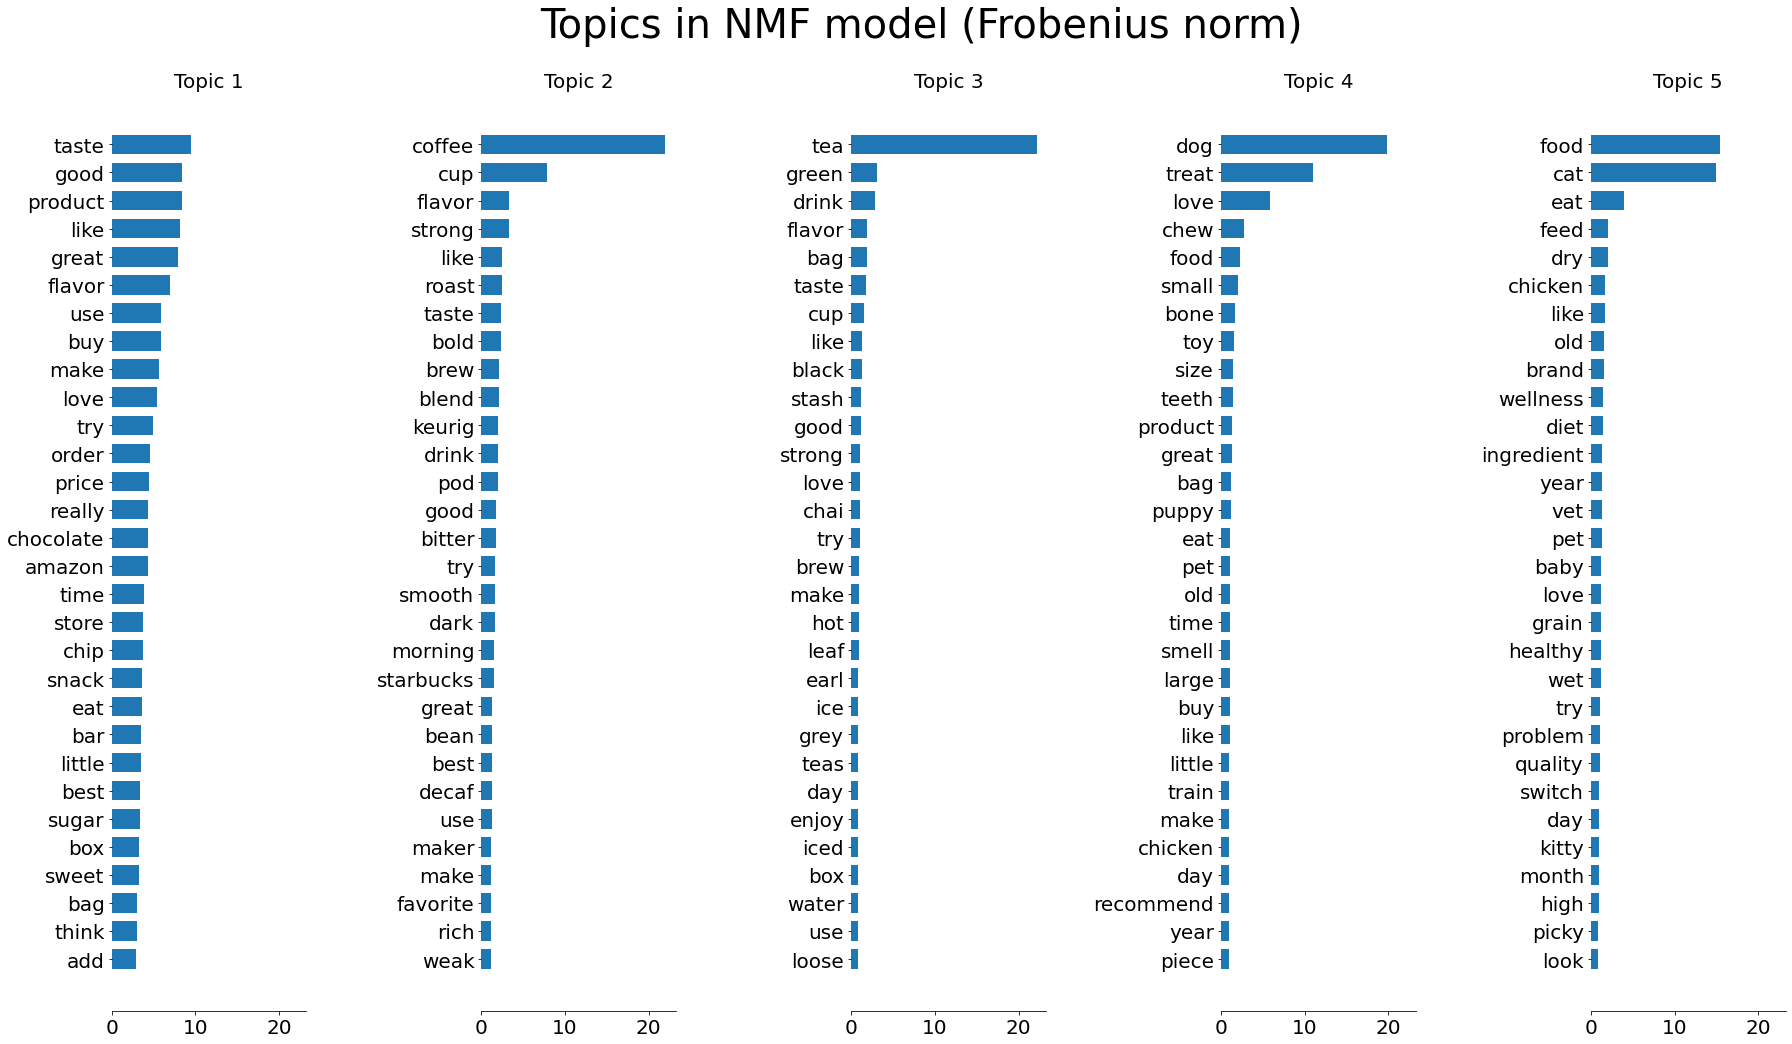

done in 270.705s.


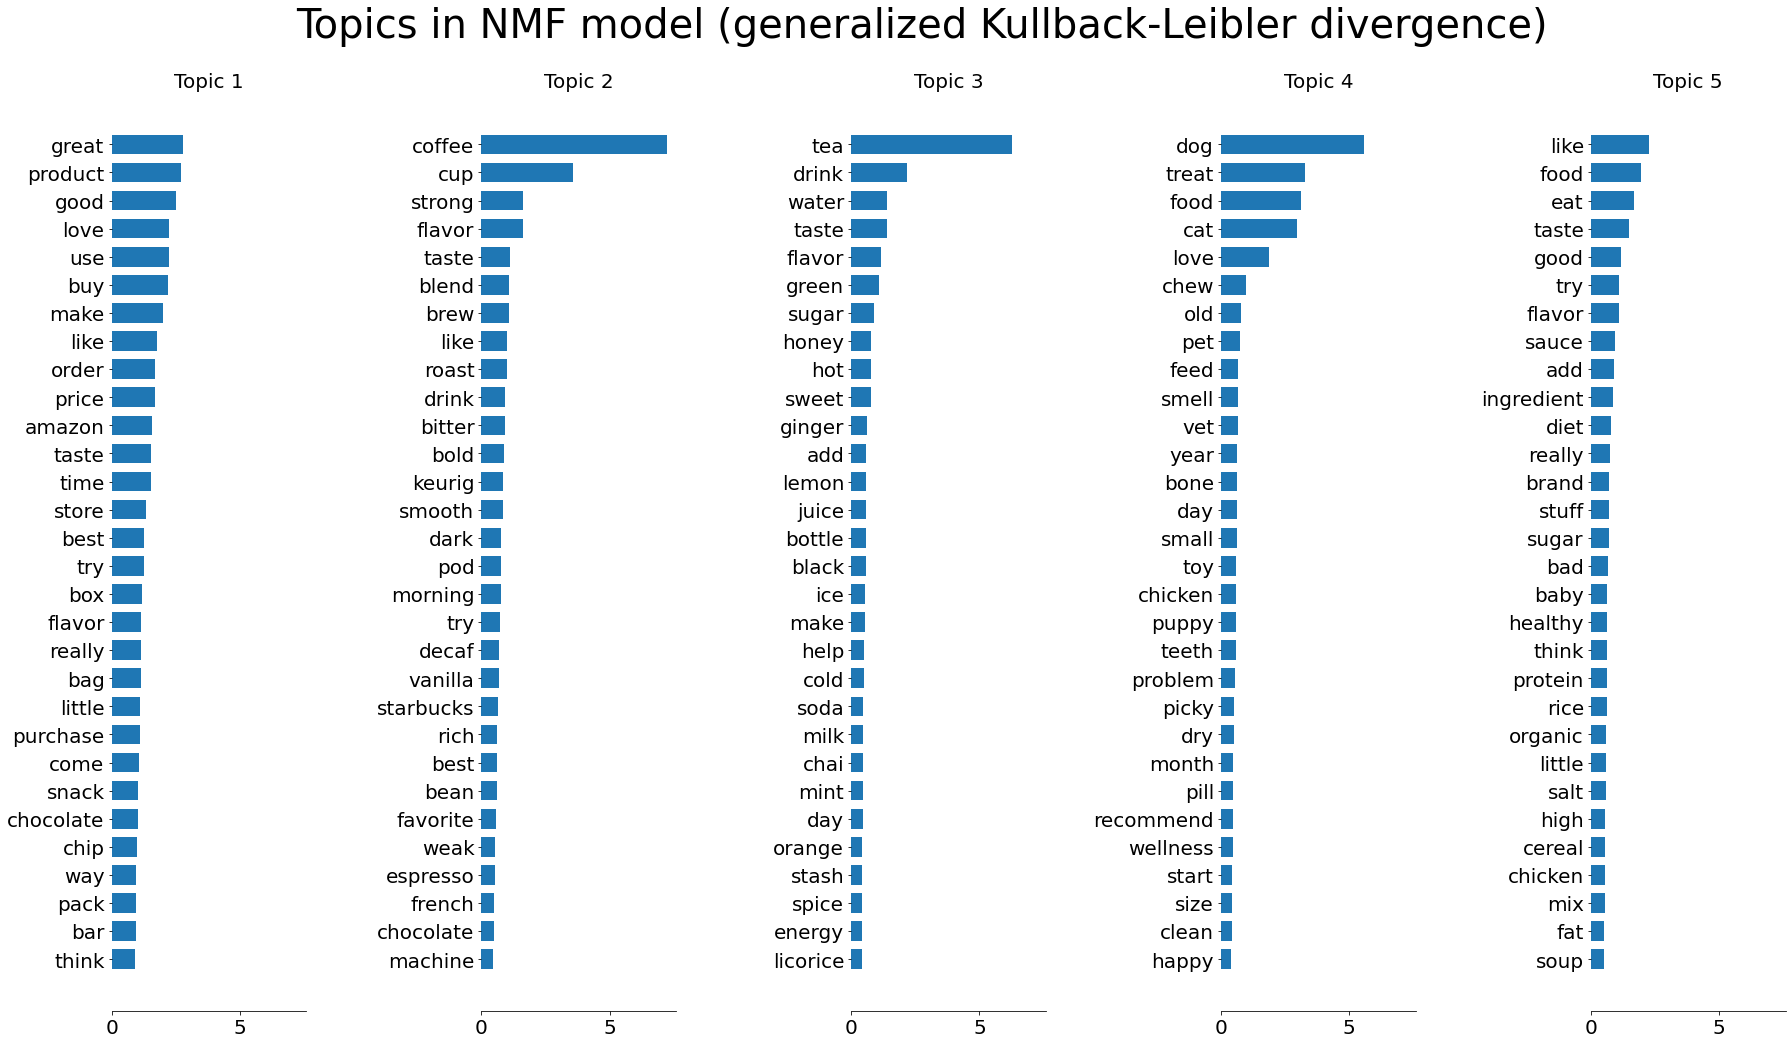

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation
n_components = 5 #topic=5
n_features = 1000
n_top_words = 30



def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(df.Text_clean.values) # input text
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
# print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
#       "n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
# print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
#       "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')






Based on the NMF model, there are some similarity in topics with the outputs in LDA. In the NMF model, there is a topic covers amazon service and pet foods. However, in the NMF model, the tea and coffee are clustered into two different clusters. This is different with LDA model where coffee and tea are clustered into one cluster. In the NMF model, there is a topic that covers ingredients whereas the LDA model clustered into snacks and desserts. It appears that the clusters in the LDA results are centered in major food categories such as snacks, desserts, drinks and pet foods. Yet, the NMF model outputs clusters in a more specific level, such as tea, coffee, ingredients and pet foods. These four categories are what American people focus on daily. Coffee, tea and pet foods are necessities for the majority people. Also, people nowadays pay great attentions on the food ingredients. It is interesting to see that the NMF model is able to extract the differences between coffee and tea whereas the LDA is not able to.

 


####e) 
Write a ‘text cleaner’ function that does the following: (i) remove stopwords2, (ii) remove all words that are shorter than 3 characters, (iii) remove all links (starting with http), (iv) remove emojis, (v) remove punctuation. Attach the code you wrote to the lemmatizer.py file in the project folder. Run the lemmatizer function and create ‘cleaned and lemmatized’ versions of Summary and Text columns. (You can name the new columns as Summary_clean and Text_clean). (5 points)








Text clean
1.   Remove stopwords
2.   remove all words are shorter than 3 characters
3.   remove all links
4.   Remove emojis
4.   Remove punnctuation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = stopwords.words('english')

def text_clean(x):
  # lower case
  x = x.lower()
  # remove stop words
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  # remove emoji
  x = x.encode(encoding="ascii", errors="ignore").decode()
  # remove hashtags
  x = re.sub("#\S+", " ", x)
  # remove mentions
  x = re.sub("@\S+", " ", x)
  # remove URL/links
  x = re.sub("https*\S+", " ", x)
  #remove punctuation
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  # remove overspaces
  x = re.sub('\s{2,}', " ", x)
  # remove ticks
  x = re.sub("\'\w+", '', x)
  # remove words shorter than 3
  x = re.sub(r'\b\w{1,2}\b', '', x)
  
  return x

df['clean_text'] = df.Text.apply(text_clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['clean_text']

0         bought several vitality canned dog food produc...
1         product arrived labeled jumbo salted peanuts t...
2         confection around centuries light pillowy citr...
3         looking secret ingredient robitussin believe f...
4         great taffy great price wide assortment yummy ...
                                ...                        
568449    great sesame chicken this good better resturan...
568450      disappointed flavor chocolate notes especial...
568451    stars small give   one training session tried ...
568452    best treats training rewarding dog good groomi...
568453    satisfied product advertised use cereal raw vi...
Name: clean_text, Length: 568454, dtype: object

In [ ]:
df['clean_summary'] = df.Summary.astype(str).apply(text_clean)

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download("stopwords")
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))


def tweet_cleaner(x):
    # lower case
  x = x.lower()
  # remove stop words
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])

  # remove URL/links
  x = re.sub("https*\S+", " ", x)
  #remove punctuation
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)


  # remove words shorter than 3
  x = re.sub(r'\b\w{1,2}\b', '', x)
  
  return x

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['Text_clean'] = df.Text.apply(lemmatize_tweet)

In [ ]:
df['Summary_clean'] = df.Summary.astype(str).apply(lemmatize_tweet)

In [ ]:
df['Summary_clean']

0               good quality dog food
1                          advertised
2                         delight say
3                      cough medicine
4                         great taffy
                     ...             
568449                        without
568450                   disappointed
568451               perfect maltipoo
568452    favorite train reward treat
568453                    great honey
Name: Summary_clean, Length: 568454, dtype: object

In [ ]:
df['Text_clean']

0         buy several vitality can dog food product find...
1         product arrive labeled jumbo salt peanut the p...
2         confection around century light pillowy citrus...
3         look secret ingredient robitussin believe find...
4         great taffy great price wide assortment yummy ...
                                ...                        
568449    great sesame chicken this good good resturants...
568450    disappointed flavor chocolate note especially ...
568451    star small give one training session try train...
568452    best treat train reward dog good groom low cal...
568453    satisfied product advertise use cereal raw vin...
Name: Text_clean, Length: 568454, dtype: object

Save the Lemmatized  and time transfered df 

Load the lemmatized data from google drive, use parquet format to save time of loading data

#### f) 
Using the cosine_similarity.py file in the project folder compute the similarity values between Summary_clean and Text_clean. Finally, create a density plot of the similarity values you have calculated. What are some of your observations? Is Summary predictive of Text? Are there any very large or very small values? (Add the graph you created to the report at the end.) (5 points)

In [ ]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)
    
##Example
##cosine_score = get_cosine(text_to_vector(clean_tweet), text_to_vector(" ".join(topic_words)))
##topic_words is a list of words; clean_tweet is a string


Convert word2vector:

In [ ]:
df['Summary_vec'] = df.Summary_clean.astype(str).apply(text_to_vector)

In [ ]:
df['Text_vec'] = df.Text_clean.apply(text_to_vector)

Compute Cosine Similarity

In [ ]:
df['Cosine_sim'] = list(map(get_cosine, df['Summary_vec'], df['Text_vec']))

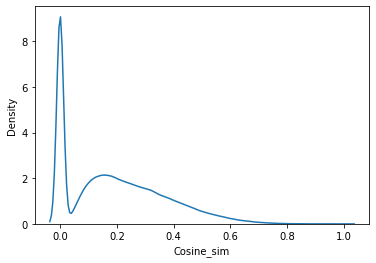

In [ ]:
sns.kdeplot(df['Cosine_sim'])

The similarity value between text and summary are not very high. The majority of the score stays below 0.6. In fact, the density is at its highest when cosine similarity is 0. The density hit to 9 when the cosine similarity ranges between -0.05 to 0.03. When cosine similarity is between 0.04 to 0.6, the density stays below 2. As the conclusion, summary does not predictive text, only very few summaries describe what the text says. For the majority of the summaries, they do not tell a good story of the texts.

Save the processed df:

In [ ]:
df.to_parquet('amazon_reviews.parquet.gzip', compression="gzip")
!cp amazon_reviews.parquet.gzip "/content/drive/MyDrive/Mini Project/"


In [ ]:
%%time
df = pd.read_parquet("/content/drive/MyDrive/Mini Project/amazon_reviews.parquet.gzip")

CPU times: user 4.78 s, sys: 1.41 s, total: 6.19 s
Wall time: 10.4 s


In [ ]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Title_len,Summary_len,Helpful_ratio,Review_len,Text_clean,Summary_clean,Review,neg,neu,pos,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,10.0,21.0,1.0,263,buy several vitality can dog food product find...,good quality dog food,good quality dog food buy several vitality can...,0.0,0.545,0.455,0.9382
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,6.0,17.0,NaN,190,product arrive labeled jumbo salt peanut the p...,advertised,good quality dog food buy several vitality can...,0.0,0.545,0.455,0.9382
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,31.0,21.0,1.0,509,confection around century light pillowy citrus...,delight say,good quality dog food buy several vitality can...,0.0,0.545,0.455,0.9382
